In [1]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle
from submissions.reappearance import dict_reappearance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

In [3]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

In [4]:
submission_team = "달려라하니"
team_submission = dict_reappearance[submission_team]
DQN = team_submission.model
ReplayMemory = team_submission.memory

C:\Users\sizzf\AppData\Local\Temp\ipykernel_2892\1323260443.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(team_submission.model_path, map_location=device))


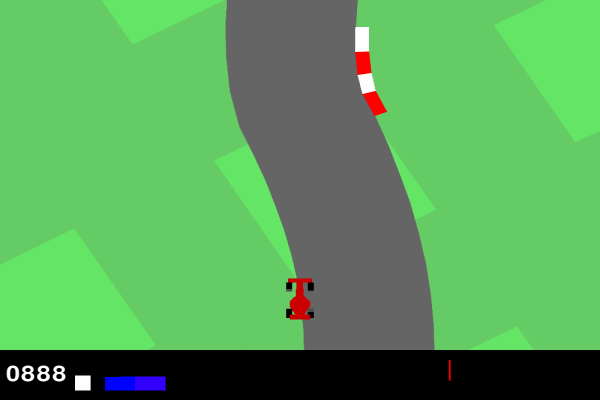

880.658730158716


In [5]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DQN(n_actions, **team_submission.hyperparameters)
agent.target_network.load_state_dict(
    torch.load(team_submission.model_path, map_location=device))

frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
      
scores += ret

print(scores)